In [1]:
import matplotlib.pyplot as plt
from transform import transform
import os.path as path
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import time
import gc

warnings.filterwarnings("ignore")

%matplotlib inline
pd.options.display.float_format = '{:.5f}'.format
pd.options.display.max_columns = 100

train_columns = ['ip', 'app', 'os', 'device', 'channel', 'click_time', 'is_attributed']
dtypes = {
    'ip'            : 'uint32',
    'app'           : 'uint16',
    'os'            : 'uint16',
    'device'        : 'uint16',
    'channel'       : 'uint16',
    'is_attributed' : 'uint8'
}

In [2]:
data_perc = 0.02 # ignorado se houver dados processados disponíveis
use_gpu = False

# carregando do csv

In [3]:
start = time.time()

has_processed_data = path.isfile('input/train_processed.csv')

filename = 'input/train_processed.csv' if has_processed_data else 'input/train.csv'
if has_processed_data:
    data_perc = 1.0

if filename=='input/train.csv':
    train_size_total = 184903890
else:
    train_size_total = sum(1 for line in open(filename))-1
train_size = int(data_perc*train_size_total)

data_train = pd.read_csv(filename, nrows=train_size, usecols=train_columns, parse_dates=['click_time'], dtype=dtypes)
print('{:.2f}s to load train data'.format(time.time()-start))

4.20s to load train data


# extraindo features interessantes

In [4]:
start = time.time()
transform(data_train)
process_time = time.time()-start
print('{:.2f}s to process data ({:.2f} lines/s)'.format(process_time, data_train.shape[0]/process_time))

0.41s to generate feature ip_clicks
0.56s to generate feature ip_clicks_on_app
0.04s to generate feature ip_clicks_on_app_perc
0.22s to generate feature app_clicks
0.20s to generate feature os_clicks
0.37s to generate feature os_clicks_on_app
0.04s to generate feature os_clicks_on_app_perc
0.33s to generate feature device_clicks
0.37s to generate feature device_clicks_on_app
0.06s to generate feature device_clicks_on_app_perc
0.36s to generate feature channel_clicks
0.44s to generate feature channel_clicks_on_app
0.05s to generate feature channel_clicks_on_app_perc
0.67s to generate feature ip_os_clicks
1.09s to generate feature ip_os_clicks_on_app
0.05s to generate feature ip_os_clicks_on_app_perc
0.79s to generate feature ip_os_device_clicks
1.13s to generate feature ip_os_device_clicks_on_app
0.05s to generate feature ip_os_device_clicks_on_app_perc
1.61s to generate feature ip_os_device_channel_clicks
1.87s to generate feature ip_os_device_channel_clicks_on_app
0.04s to generate fe

# valores médios de cada feature

### clicks seguidos de download

In [5]:
data_train[data_train['is_attributed']==1].describe().drop(columns=['is_attributed'])[1:3]

,click_time,ip_clicks,ip_clicks_on_app,ip_clicks_on_app_perc,app_clicks,os_clicks,os_clicks_on_app,os_clicks_on_app_perc,device_clicks,device_clicks_on_app,device_clicks_on_app_perc,channel_clicks,channel_clicks_on_app,channel_clicks_on_app_perc,ip_os_clicks,ip_os_clicks_on_app,ip_os_clicks_on_app_perc,ip_os_device_clicks,ip_os_device_clicks_on_app,ip_os_device_clicks_on_app_perc,ip_os_device_channel_clicks,ip_os_device_channel_clicks_on_app,ip_os_device_channel_clicks_on_app_perc,ip_duration,ip_clicks_intervals_std,ip_clicks_frequency,ip_duration_on_app,ip_clicks_on_app_intervals_std,ip_duration_on_app_perc,ip_clicks_on_app_frequency,app_duration,app_clicks_intervals_std,app_clicks_frequency,os_duration,os_clicks_intervals_std,os_clicks_frequency,os_duration_on_app,os_clicks_on_app_intervals_std,os_duration_on_app_perc,os_clicks_on_app_frequency,device_duration,device_clicks_intervals_std,device_clicks_frequency,device_duration_on_app,device_clicks_on_app_intervals_std,device_duration_on_app_perc,device_clicks_on_app_frequency,channel_duration,channel_clicks_intervals_std,channel_clicks_frequency,channel_duration_on_app,channel_clicks_on_app_intervals_std,channel_duration_on_app_perc,channel_clicks_on_app_frequency,ip_os_duration,ip_os_clicks_intervals_std,ip_os_clicks_frequency,ip_os_duration_on_app,ip_os_clicks_on_app_intervals_std,ip_os_duration_on_app_perc,ip_os_clicks_on_app_frequency,ip_os_device_duration,ip_os_device_clicks_intervals_std,ip_os_device_clicks_frequency,ip_os_device_duration_on_app,ip_os_device_clicks_on_app_intervals_std,ip_os_device_duration_on_app_perc,ip_os_device_clicks_on_app_frequency,ip_os_device_channel_duration,ip_os_device_channel_clicks_intervals_std,ip_os_device_channel_clicks_frequency,ip_os_device_channel_duration_on_app,ip_os_device_channel_clicks_on_app_intervals_std,ip_os_device_channel_duration_on_app_perc,ip_os_device_channel_clicks_on_app_frequency,app_attributed_perc,os_attributed_perc,device_attributed_perc,channel_attributed_perc
mean,16.41970,440.52196,13.56885,0.36671,80475.13880,332905.14068,9588.62108,0.20998,2403345.50925,74561.54972,0.20554,28377.33846,16238.93774,0.50083,58.03748,3.46016,0.64218,54.73212,3.33516,0.64641,2.70499,2.29925,0.96768,4005.98494,511.62185,0.31513,957.70514,868.09130,0.44074,0.68771,8254.75314,31.61830,8.97318,10433.98824,4.58738,26.34862,7394.73463,123.60556,0.74595,1.18328,11109.35398,54.71350,185.58235,7901.34301,98.80573,0.73574,8.31242,7897.23055,8.55660,3.64789,7690.20452,48.79101,0.97615,2.09993,1693.57873,732.38588,0.53232,380.20201,898.72009,0.64805,0.79482,1649.65229,732.01831,0.53948,351.95295,897.07407,0.65152,0.80047,289.42487,902.85898,0.81888,214.95436,911.07422,0.96560,0.83654,0.23967,0.04188,0.05065,0.17555
std,0.55883,2127.49999,123.71152,0.42632,151733.89318,383064.18299,24315.18395,0.31732,1603589.35694,144323.13693,0.30135,58206.42276,38357.28255,0.35165,401.16146,29.43444,0.42330,377.52997,28.35346,0.42295,22.70098,21.07389,0.13442,3294.42966,462.69607,0.55090,2120.30154,351.83592,0.46247,0.53040,1424.10216,108.22259,17.13156,2451.48104,24.57976,29.28137,1566.39562,271.72877,0.22528,2.94735,2930.88232,219.75311,123.37826,2104.91286,262.66131,0.20817,16.26939,716.15654,53.37012,7.54953,811.04679,148.41974,0.08980,4.97556,2620.29176,444.50324,0.63599,1316.74452,315.36359,0.46001,0.49437,2599.15730,438.47754,0.63611,1263.40628,308.34045,0.45935,0.49134,1089.30754,305.91210,0.49624,921.03967,287.17197,0.17542,0.46377,0.27028,0.06912,0.11624,0.24592


### clicks não seguidos de downloads

In [6]:
data_train[data_train['is_attributed']==0].describe().drop(columns=['is_attributed'])[1:3]

,click_time,ip_clicks,ip_clicks_on_app,ip_clicks_on_app_perc,app_clicks,os_clicks,os_clicks_on_app,os_clicks_on_app_perc,device_clicks,device_clicks_on_app,device_clicks_on_app_perc,channel_clicks,channel_clicks_on_app,channel_clicks_on_app_perc,ip_os_clicks,ip_os_clicks_on_app,ip_os_clicks_on_app_perc,ip_os_device_clicks,ip_os_device_clicks_on_app,ip_os_device_clicks_on_app_perc,ip_os_device_channel_clicks,ip_os_device_channel_clicks_on_app,ip_os_device_channel_clicks_on_app_perc,ip_duration,ip_clicks_intervals_std,ip_clicks_frequency,ip_duration_on_app,ip_clicks_on_app_intervals_std,ip_duration_on_app_perc,ip_clicks_on_app_frequency,app_duration,app_clicks_intervals_std,app_clicks_frequency,os_duration,os_clicks_intervals_std,os_clicks_frequency,os_duration_on_app,os_clicks_on_app_intervals_std,os_duration_on_app_perc,os_clicks_on_app_frequency,device_duration,device_clicks_intervals_std,device_clicks_frequency,device_duration_on_app,device_clicks_on_app_intervals_std,device_duration_on_app_perc,device_clicks_on_app_frequency,channel_duration,channel_clicks_intervals_std,channel_clicks_frequency,channel_duration_on_app,channel_clicks_on_app_intervals_std,channel_duration_on_app_perc,channel_clicks_on_app_frequency,ip_os_duration,ip_os_clicks_intervals_std,ip_os_clicks_frequency,ip_os_duration_on_app,ip_os_clicks_on_app_intervals_std,ip_os_duration_on_app_perc,ip_os_clicks_on_app_frequency,ip_os_device_duration,ip_os_device_clicks_intervals_std,ip_os_device_clicks_frequency,ip_os_device_duration_on_app,ip_os_device_clicks_on_app_intervals_std,ip_os_device_duration_on_app_perc,ip_os_device_clicks_on_app_frequency,ip_os_device_channel_duration,ip_os_device_channel_clicks_intervals_std,ip_os_device_channel_clicks_frequency,ip_os_device_channel_duration_on_app,ip_os_device_channel_clicks_on_app_intervals_std,ip_os_device_channel_duration_on_app_perc,ip_os_device_channel_clicks_on_app_frequency,app_attributed_perc,os_attributed_perc,device_attributed_perc,channel_attributed_perc
mean,16.40986,1069.64727,139.93108,0.15533,333890.07351,440240.43129,40934.58351,0.09770,3281693.75833,301711.37306,0.09735,126930.83056,75184.11423,0.65480,170.94280,29.13911,0.25878,156.02631,27.00997,0.26453,20.22546,16.68296,0.86614,6804.71359,165.57798,0.14585,5102.09918,464.98135,0.72672,0.09070,9046.10930,2.05884,38.53866,11451.68660,3.34342,34.82508,8186.78102,7.67740,0.73760,4.97056,12653.46616,0.72561,253.53736,8981.64530,2.71322,0.71652,34.80852,7898.51601,0.90694,16.35110,7819.71383,1.90043,0.99355,9.71004,4142.69483,317.84440,0.14761,2645.34901,606.62180,0.61744,0.24265,4025.99986,323.65210,0.15350,2555.25056,611.14913,0.61634,0.24994,1832.52788,673.35338,0.39176,1595.74624,697.30506,0.90460,0.43028,0.00131,0.00165,0.00164,0.00142
std,0.55730,3049.38794,481.43405,0.15191,173189.93256,379124.33863,44718.83584,0.07364,787418.57371,174022.67891,0.07100,112613.99554,69821.49659,0.29208,583.76851,100.34245,0.24408,535.15858,92.56570,0.24785,62.82812,56.78182,0.22892,1617.47267,216.31495,0.41192,2637.65751,460.14335,0.32964,0.27945,2099.42861,13.28521,22.33978,2058.70619,13.03259,28.64131,1507.53688,47.73061,0.17330,5.53789,1248.81018,19.08679,59.08351,2082.00718,27.33608,0.17306,22.05749,952.14942,7.10993,14.68864,723.17252,18.00807,0.04615,9.08697,2843.09936,370.16004,0.52851,2717.05569,496.32959,0.40125,0.46472,2839.48127,374.41876,0.54496,2681.47461,496.11079,0.40272,0.47036,2413.32448,482.35795,0.55408,2293.47304,463.54647,0.27048,0.52882,0.01367,0.00764,0.00755,0.01198


# distribuições das variáveis

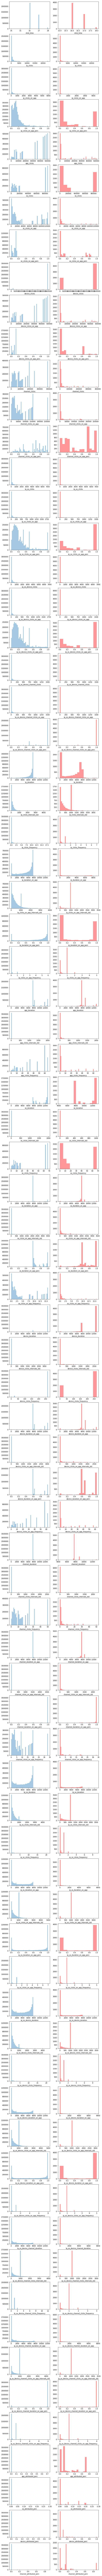

In [7]:
fig = plt.figure(figsize=(10,300))
count = 1
for column in data_train.columns:
    if column=='is_attributed':
        continue
    fig.add_subplot(data_train.shape[1], 2, count)
    sns.distplot(data_train[data_train['is_attributed']==0][column], kde=False)
    count += 1
    fig.add_subplot(data_train.shape[1], 2, count)
    sns.distplot(data_train[data_train['is_attributed']==1][column], kde=False, color='red')
    count += 1

# treinamento

In [8]:
from sklearn.model_selection import train_test_split
import xgboost as xgb

X = data_train.drop(columns=['is_attributed'])
y = data_train['is_attributed']

In [9]:
start = time.time()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)
del X, y
gc.collect()
print('{:.2f}s to split data in train/test'.format(time.time()-start))

13.24s to split data in train/test


In [10]:
start = time.time()
unbalance_factor = data_train[data_train['is_attributed']==0].shape[0]/data_train[data_train['is_attributed']==1].shape[0]
del data_train
gc.collect()
print('{:.2f}s to compute unbalance factor: {}'.format(time.time()-start, unbalance_factor))

16.26s to compute unbalance factor: 578.9995294855709


In [11]:
# https://github.com/dmlc/xgboost/blob/master/doc/parameter.md
xgb_params = {
    'eta': 0.2,
    'max_leaves': 2048,
    'subsample': 0.8,
    'colsample_bytree': 0.7,
    'colsample_bylevel':0.7,
    'min_child_weight':0,
    'alpha': 5,
    'scale_pos_weight': unbalance_factor,
    'eval_metric': 'auc',
    'random_state': int(time.time()),
    'nthread': 4,
    'silent': True,
    'max_depth': 0,
    'grow_policy': 'lossguide',
    'tree_method': 'hist',
    'predictor': 'cpu_predictor',
    'objective': 'binary:logistic'
}

if use_gpu:
    xgb_params.update({'tree_method':'gpu_hist', 'predictor':'gpu_predictor', 'objective':'gpu:binary:logistic'})

In [12]:
start = time.time()
dtrain = xgb.DMatrix(X_train, y_train)
dvalid = xgb.DMatrix(X_test, y_test)
del X_train, y_train, X_test, y_test
gc.collect()
print('{:.2f}s to create xgboost data structures'.format(time.time()-start))

268.57s to create xgboost data structures


In [13]:
# watch accuracy in training and validation
watchlist = [(dtrain, 'training'), (dvalid, 'validation')]

start = time.time()
model = xgb.train(xgb_params, dtrain, 1000, watchlist, maximize=True, early_stopping_rounds = 25, verbose_eval=5)
del dvalid, dtrain
gc.collect()
print('{:.2f}s to perform training'.format(time.time()-start))

[0]	training-auc:0.987853	validation-auc:0.949942
Multiple eval metrics have been passed: 'validation-auc' will be used for early stopping.

Will train until validation-auc hasn't improved in 25 rounds.
[5]	training-auc:0.99889	validation-auc:0.929003
[10]	training-auc:0.999121	validation-auc:0.951559
[15]	training-auc:0.999312	validation-auc:0.953766
[20]	training-auc:0.999487	validation-auc:0.956432
[25]	training-auc:0.999605	validation-auc:0.959266
[30]	training-auc:0.999679	validation-auc:0.960204
[35]	training-auc:0.999724	validation-auc:0.960309
[40]	training-auc:0.999761	validation-auc:0.962455
[45]	training-auc:0.999789	validation-auc:0.960611
[50]	training-auc:0.999809	validation-auc:0.958917
[55]	training-auc:0.999826	validation-auc:0.959894
[60]	training-auc:0.999839	validation-auc:0.959783
[65]	training-auc:0.999852	validation-auc:0.958447
Stopping. Best iteration:
[40]	training-auc:0.999761	validation-auc:0.962455

185.00s to perform training


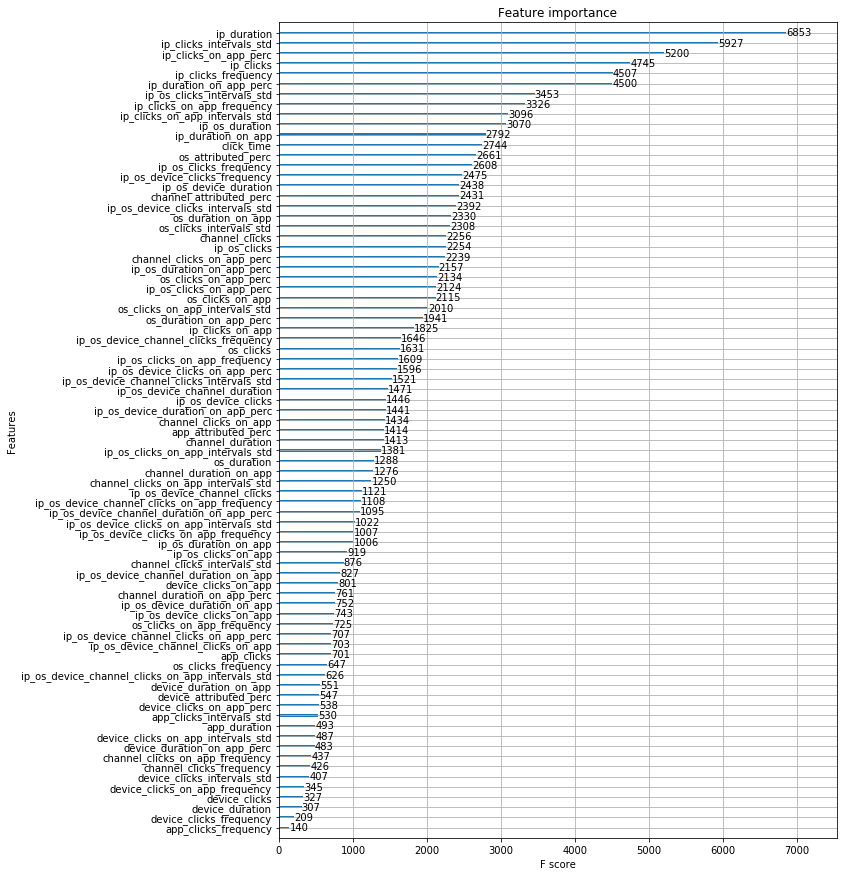

In [14]:
_, ax = plt.subplots(figsize=(10,15))
xgb.plot_importance(model, ax=ax)